In [1]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# 加载数据集
# data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a
X_train_orig,y_train_orig = load_svmlight_file('data/a9a')
X_val_orig, y_val_orig = load_svmlight_file('data/a9a.t', n_features=123)

# 转换为列向量
X_train = X_train_orig.T.toarray()
X_val = X_val_orig.T.toarray()
y_train = np.reshape(y_train_orig,(1,y_train_orig.shape[0]))
y_val = np.reshape(y_val_orig,(1,y_val_orig.shape[0]))
y_train[y_train<0]=0
y_val[y_val<0]=0
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(123, 32561) (123, 16281) (1, 32561) (1, 16281)


In [3]:
# 用零初始化参数
def init_parameters_with_zeros(dim):
    W = np.zeros((dim,1))
    b = 0
    return W,b

In [4]:
# sigmoid 函数
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [5]:
# 前向传播和反向传播
def propagate(W,b,X,Y):
    m = X.shape[1]

    # 前向传播
    A = sigmoid(np.dot(W.T,X)+b)
    # 计算cost
    cost = (np.dot(Y,np.log(A).T)+np.dot((1-Y),np.log(1-A).T))/(-m)
    
    # 反向传播
    gW = np.dot(X,(A-Y).T)/m  
    gb = np.sum(A-Y)/m
    
    cost = np.squeeze(cost)
    return cost,gW,gb

In [6]:
def predict(W,b,X):
    m = X.shape[1]
    A = sigmoid(np.dot(W.T,X)+b)
    Y_prediction = np.zeros((1,m))
    Y_prediction[A>=0.5]=1
#     Y_prediction[A<0.5]=0
#     print(A)
    return Y_prediction

In [7]:
def random_batches(X,Y,batch_size):
    m = X.shape[1]
    
    batches = []
    
    # 样本随机排列
    permutation = np.random.permutation(m)
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]

    
    num_batches = math.floor(m/batch_size)
    for i in range(num_batches):
        batch_X = shuffled_X[:,i*batch_size:(i+1)*batch_size]
        batch_Y = shuffled_Y[:,i*batch_size:(i+1)*batch_size]
        
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    if m % batch_size != 0:
        batch_X = shuffled_X[:,num_batches*batch_size:m]
        batch_Y = shuffled_Y[:,num_batches*batch_size:m]
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    return batches
    

In [8]:
def model(X_train, Y_train, X_val, Y_val, batch_size = 64, num_epochs = 200, max_num_iterations = None, learning_rate = 0.01, optimizer = "GD", print_cost = False,
         decay_rate = 0.9):
    
    
    eps = 1e-8
    
    beta = 0.9
    
    W_cache = 0
    b_cache = 0
    
    delta_with_W = 0
    delta_with_b = 0
    delta_W = 0
    delta_b = 0
    
    beta1 = 0.9
    beta2 = 0.999
    vgW = 0
    sgW = 0
    vgb = 0
    sgb = 0
    
    # 保存训练集和验证集上的cost
    train_cost_log = []
    val_cost_log = []
    train_accuracy_log = []
    val_accuracy_log = []
    
    # 初始化参数
    W,b = init_parameters_with_zeros(X_train.shape[0])
    
    
    it = 0
    for i in range(num_epochs):
        if max_num_iterations and it>max_num_iterations:
                break
    
        batches = random_batches(X_train, Y_train, batch_size)
        
#         # 计算验证集上的cost
#         val_cost,_,_= propagate(W,b,X_val,Y_val)
#         val_cost_log.append(val_cost)
        
        for batch in batches:
            it+=1
            if max_num_iterations and it>max_num_iterations:
                break
            
            (X_batch, Y_batch) = batch
            
    
            # 进行前向传播、反向传播，计算cost和梯度
            train_cost, gW, gb = propagate(W,b,X_batch,Y_batch)
            val_cost,_,_= propagate(W,b,X_val,Y_val)

#             Y_batch_prediction = predict(W,b,X_batch)
#             Y_val_prediction = predict(W,b,X_val)
#             train_accuracy = 100 - np.mean(np.abs(Y_batch_prediction - Y_batch) / 2) * 100
#             val_accuracy = 100 - np.mean(np.abs(Y_val_prediction - Y_val) / 2) * 100

            # 保存cost
            train_cost_log.append(train_cost)
            val_cost_log.append(val_cost)
#             train_accuracy_log.append(train_accuracy)
#             val_accuracy_log.append(val_accuracy)
    
            # 更新参数
            if optimizer is "GD": # Gradient Descent
                W = W-learning_rate*gW
                b = b-learning_rate*gb
            elif optimizer is "NAG": # Nesterov Accelerated Gradient
                vgW_prev = vgW
                vgW = beta * vgW - learning_rate * gW
                W = W - beta * vgW_prev + (1+beta) * vgW
                vgb_prev = vgb
                vgb = beta * vgb - learning_rate * gb
                b = b - beta * vgb_prev + (1+beta) * vgb
                
            elif optimizer is "RMSProp": # RMSProp
                W_cache = decay_rate * W_cache + (1 - decay_rate) * gW**2
                W = W - learning_rate * gW / (np.sqrt(W_cache) + eps)
                b_cache = decay_rate * b_cache + (1 - decay_rate) * gb**2
                b = b - learning_rate * gb / (np.sqrt(b_cache) + eps)

            elif optimizer is "AdaDelta": # AdaDelta
                W_cache = beta * W_cache + (1-beta) * gW**2
                delta_W =  - np.sqrt(delta_with_W + eps)/(np.sqrt(W_cache+eps)+eps) * gW
                W = W + delta_W
                delta_with_W = beta * delta_with_W + (1-beta)* delta_W ** 2
                
                b_cache = beta * b_cache + (1-beta) * gb**2
                delta_b =  - np.sqrt(delta_with_b + eps)/(np.sqrt(b_cache)+eps) * gb
                b = b + delta_b
                delta_with_b = beta * delta_with_b + (1-beta)* delta_b ** 2
                
            elif optimizer is "Adam": # Adam
                vgW = beta1*vgW + (1-beta1)*gW
                sgW = beta2*sgW + (1-beta2)*(gW**2)
                W = W - learning_rate * vgW / (np.sqrt(sgW) + eps)
                vgb = beta1*vgb + (1-beta1)*gb
                sgb = beta2*sgb + (1-beta2)*(gb**2)
                b = b - learning_rate * vgb / (np.sqrt(sgb) + eps)

        
        if print_cost and i % 10 == 0:
            print ("After epoch %i, train cost: %f" %(i, train_cost))

    return W,b,train_cost_log,val_cost_log,train_accuracy_log,val_accuracy_log

In [9]:
num_epochs = 80
batch_size = 4096
_,_,_,loss_NAG,_,accuracy_NAG = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.01,optimizer = 'NAG',print_cost=True)
_,_,_,loss_RMSProp,_,accuracy_RMSProp = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.01,optimizer = 'RMSProp',print_cost=True)
_,_,_,loss_AdaDelta,_,accuracy_AdaDelta = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.01,optimizer = 'AdaDelta',print_cost=True)
_,_,_,loss_Adam,_,accuracy_Adam = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.01,optimizer = 'Adam',print_cost=True)
_,_,_,loss_GD,_,accuracy_GD = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)

After epoch 0, train cost: 0.586477
After epoch 10, train cost: 0.393748
After epoch 20, train cost: 0.379802
After epoch 30, train cost: 0.368036
After epoch 40, train cost: 0.348185
After epoch 50, train cost: 0.350419
After epoch 60, train cost: 0.354723
After epoch 70, train cost: 0.337273
After epoch 0, train cost: 0.469771
After epoch 10, train cost: 0.327452
After epoch 20, train cost: 0.318778
After epoch 30, train cost: 0.326180
After epoch 40, train cost: 0.319480
After epoch 50, train cost: 0.315902
After epoch 60, train cost: 0.325488
After epoch 70, train cost: 0.320887
After epoch 0, train cost: 0.684373
After epoch 10, train cost: 0.596042
After epoch 20, train cost: 0.527244
After epoch 30, train cost: 0.483070
After epoch 40, train cost: 0.446460
After epoch 50, train cost: 0.425667
After epoch 60, train cost: 0.386272
After epoch 70, train cost: 0.385800
After epoch 0, train cost: 0.397479
After epoch 10, train cost: 0.318940
After epoch 20, train cost: 0.319335
After

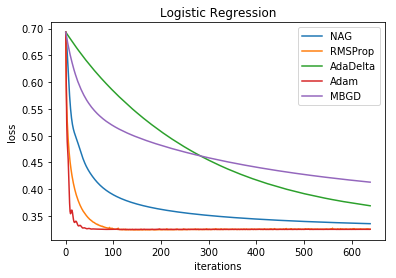

In [10]:
# 画图

plt.plot(loss_NAG, label='NAG')
plt.plot(loss_RMSProp, label='RMSProp')
plt.plot(loss_AdaDelta, label='AdaDelta')
plt.plot(loss_Adam, label='Adam')
plt.plot(loss_GD, label='MBGD')
# plt.plot(val_loss_log,'b', label = 'validation set')


plt.legend() # 图例
# plt.axis([50,100,0,0.4])
plt.ylabel('loss')
plt.xlabel('iterations')
# plt.yscale('log')
plt.title('Logistic Regression')
# plt.show()
plt.savefig('report/logistic_regression_loss_with_different_optimization_algorithm.eps', format='eps', dpi=1000)

In [11]:
num_epochs = 800
max_num_iterations = 1000
_,_,_,loss_batch_size_1,_,accuracy_batch_size_1 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=1 ,learning_rate = 0.01,optimizer = 'Adam',print_cost=True)
# _,_,_,loss_batch_size_2,_,accuracy_batch_size_2 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=2 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
# _,_,_,loss_batch_size_4,_,accuracy_batch_size_4 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=4 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
# _,_,_,loss_batch_size_8,_,accuracy_batch_size_8 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=8 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
_,_,_,loss_batch_size_16,_,accuracy_batch_size_16 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=16 ,learning_rate = 0.01,optimizer = 'Adam',print_cost=True)
_,_,_,loss_batch_size_256,_,accuracy_batch_size_256 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=256,learning_rate = 0.01,optimizer = 'Adam',print_cost=True)
_,_,_,loss_batch_size_4096,_,accuracy_batch_size_4096 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=4096 ,learning_rate = 0.01,optimizer = 'Adam',print_cost=True)


After epoch 0, train cost: 0.005825
After epoch 0, train cost: 0.351527
After epoch 0, train cost: 0.419241
After epoch 0, train cost: 0.411486
After epoch 10, train cost: 0.318430
After epoch 20, train cost: 0.320421
After epoch 30, train cost: 0.326994
After epoch 40, train cost: 0.317208
After epoch 50, train cost: 0.320117
After epoch 60, train cost: 0.322274
After epoch 70, train cost: 0.316081
After epoch 80, train cost: 0.337001
After epoch 90, train cost: 0.320375
After epoch 100, train cost: 0.332623
After epoch 110, train cost: 0.311010
After epoch 120, train cost: 0.313709


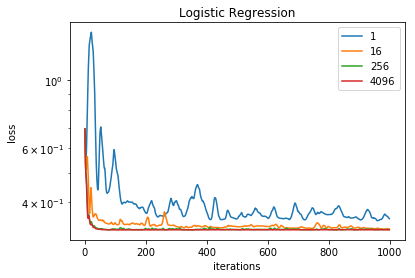

In [12]:
plt.plot(loss_batch_size_1, label='1')
# plt.plot(loss_batch_size_2, label='2')
# plt.plot(loss_batch_size_4 , label='4')
# plt.plot(loss_batch_size_8, label='8')
plt.plot(loss_batch_size_16, label='16')
plt.plot(loss_batch_size_256, label='256')
plt.plot(loss_batch_size_4096, label='4096')
# plt.plot(GD_loss, label='MGD')
# plt.plot(val_loss_log,'b', label = 'validation set')


plt.legend() # 图例
# plt.axis([0,10,0.3,0.5])
plt.ylabel('loss')
plt.xlabel('iterations')
plt.yscale('log')
plt.title('Logistic Regression')
plt.show()